# Tutorial for Split Learning and Its Related Research

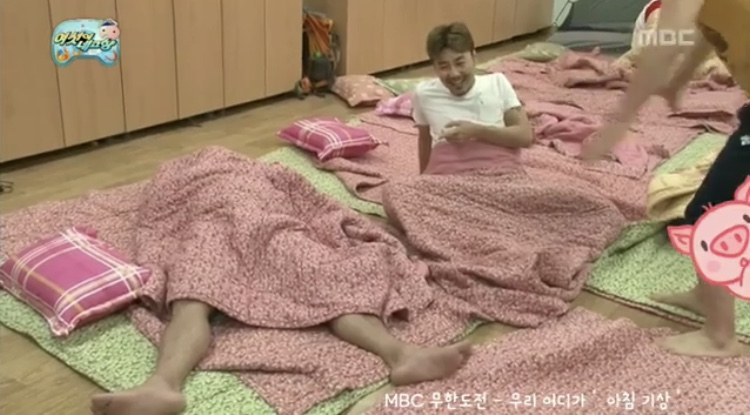

## 1. What is Split Learning?

- A basic concept of split learning is splitting a neural network into multiple sub-neural-networks.

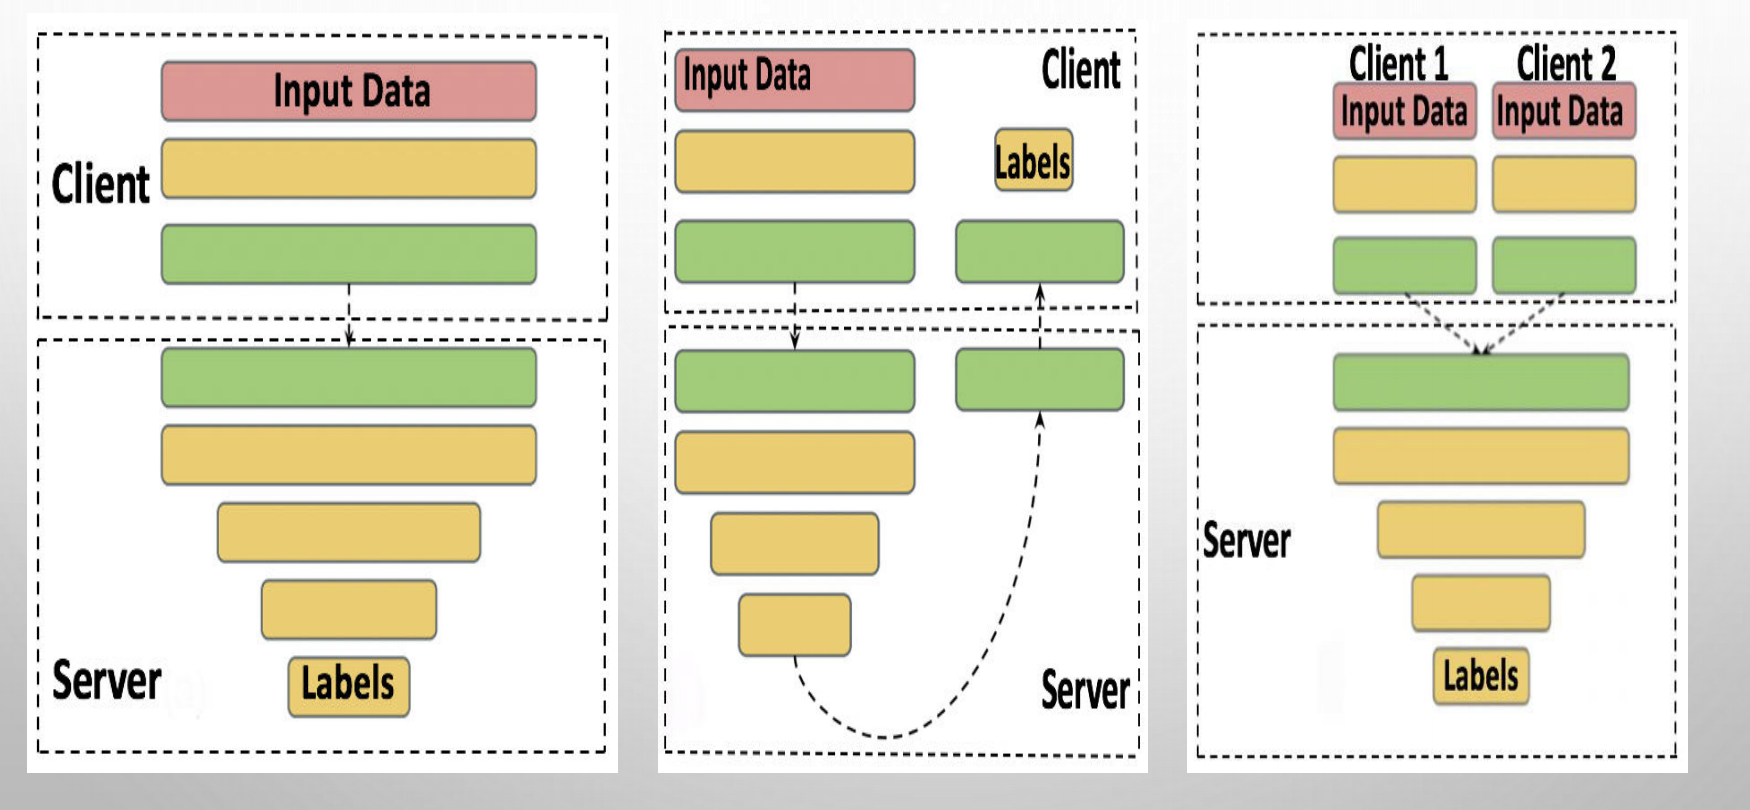


1. **Default type of split learning**: A client processes a part of neural network (front) and deliver the output to the server. Then, the server forwards the received data into remainder of the neural network (end). 
2. **U-shape split learning**
3. **Fusing multiple client's output**

In this tutorial, we are going to test default type of split learning.

Also, privacy risk in split learning is introduced.

## 2. Code Implementation

### 2.1. Configuration

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import numpy as np
from tqdm import tqdm
device = 'cuda:0'

/home/jgjang/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1. Define SplitNN model 

In [2]:
class SplitNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.main_1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            )
        self.main_2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes),
            )
    def forward(self,x):
        return self.main_2(self.main_1(x))

2. Build dataloader (MNIST)

In [3]:
num_classes = 10
batch_size = 256
data_transform =  transforms.Compose([transforms.ToTensor(), 
                                      transforms.Normalize((0.5,), (0.5,))
                                      ])
data_train = datasets.MNIST(root= './DATA', train= True, 
                             download = True, transform=data_transform)
data_test = datasets.MNIST(root= './DATA', train= False,
                            download = True, transform=data_transform)
        
trainloader = torch.utils.data.DataLoader(data_train, batch_size= batch_size, 
                                          shuffle = True, num_workers=1)
testloader = torch.utils.data.DataLoader(data_test, batch_size= batch_size, 
                                         shuffle = False, num_workers=1)


### 2.2. Train SplitNN

In [4]:
def test(model):
    model.eval()
    acc_list = list()
    for batch_idz, (inputs, labels) in enumerate(testloader):
        inputs, labels = inputs.to(device), labels.to(device)
        # Forward all exit points' output
        y = model(inputs)
        # Concatenate the result 
        inference = torch.argmax(y, dim=1)
        correct = (inference.detach() == labels).float().mean().item()
        acc_list.append(correct)
    print(f'| Accuracy is {np.mean(acc_list)}' )

def main():
    # Load Paramters
    lr = 0.003 
    epoch = 10
    # Load Model
    model = SplitNN(num_classes = num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr =lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch)
    for ep in range(epoch):
        model.train()
        loss_ep = list()
        for batch_idz, (inputs, labels) in tqdm(enumerate(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            #Forwrad each exit point's output
            output = model(inputs)
            # Weighted sum -> loss function
            loss = criterion(output, labels) 
            loss.backward()
            optimizer.step()
            loss_ep.append(loss.detach().mean().item())
        scheduler.step()
        print(f'{ep}-th epoch loss is {np.mean(loss_ep)}')
        if ep % 5 == 4:
            test(model)
    return model
target_model = main()

235it [00:16, 13.86it/s]

0-th epoch loss is 0.4627530246973038



235it [00:14, 15.84it/s]

1-th epoch loss is 0.15886434595635596



235it [00:14, 16.01it/s]

2-th epoch loss is 0.11177526435002368



235it [00:15, 15.63it/s]

3-th epoch loss is 0.09110142751101484



235it [00:14, 15.96it/s]

4-th epoch loss is 0.06950799476434576


| Accuracy is 0.9728515625


235it [00:15, 15.48it/s]

5-th epoch loss is 0.048190489387575614



235it [00:15, 15.61it/s]

6-th epoch loss is 0.03365765352971218



235it [00:14, 15.81it/s]

7-th epoch loss is 0.020345198624628656



235it [00:14, 15.82it/s]

8-th epoch loss is 0.012727585695981187



235it [00:14, 15.81it/s]

9-th epoch loss is 0.00911826038029679


| Accuracy is 0.98203125


### 2.3. Reconstruction Attack

- Prepare new dataset 
- For inversion attack EMNIST dataset is used.
- This is a kind of autoencoder; however, there will be possible further extension of this kind of privacy attack.

In [5]:
num_classes = 10
batch_size = 256
data_transform =  transforms.Compose([transforms.ToTensor(), 
                                      transforms.Normalize((0.485,), (0.225,))
                                      ])
data_train = datasets.EMNIST(root= './DATA', train= True, split='balanced',
                             download = True, transform=data_transform)
data_test = datasets.MNIST(root= './DATA', train= False,
                            download = True, transform=data_transform)
        
emnist_train_loader = torch.utils.data.DataLoader(data_train, batch_size= batch_size, 
                                          shuffle = True, num_workers=1)
mnist_test_loader = torch.utils.data.DataLoader(data_test, batch_size= batch_size, 
                                         shuffle = False, num_workers=1)


- Define Attacker

In [6]:
class Attacker(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers= nn.Sequential(
                      nn.Linear(1024, 1000),
                      nn.ReLU(),
                      nn.Linear(1000, 784),
                      nn.Tanh()
                    )
 
    def forward(self, x):
        return self.layers(x)

- Train Attacker

In [7]:
attacker = Attacker().to(device)
optimizer_att = torch.optim.Adam(attacker.parameters(), lr=1e-4)

for i in range(5):
    for data, targets in emnist_train_loader:
        data = data.to(device)
        # Reset gradients
        optimizer_att.zero_grad()

        # First, get outputs from the target model
        target_outputs = target_model.main_1(data)

        # Next, recreate the data with the attacker
        attack_outputs = attacker(target_outputs)

        # We want attack outputs to resemble the original data
        loss = ((data.reshape([-1, 28*28]) - attack_outputs)**2).mean()

        # Update the attack model
        loss.backward()
        optimizer_att.step()

### 2.4. Reconstruction Attack Result

In [8]:
index = 16
data = data_test[index][0].to(device)

target_outputs = target_model.main_1(data)
recreated_data = attacker(target_outputs)


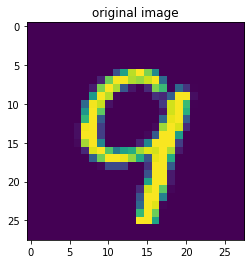

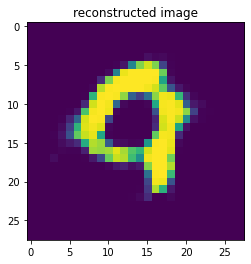

In [9]:
from matplotlib import pyplot as plt
plt.imshow(data.detach().cpu().numpy().reshape(28,28), interpolation='nearest')
plt.title('original image')
plt.show()

plt.imshow(recreated_data.detach().cpu().numpy().reshape(28,28), interpolation='nearest')
plt.title('reconstructed image')
plt.show()